# HR-аналитика

Аналитики HR отдела компании "Работа с заботой" помогают бизнесу оптимизировать управление персоналом: на основе данных предлагают, как избежать финансовых потерь и оттока сотрудников. И в этом аналитикам пригодится машинное обучение.

У нас будет несколько задач:
1. Построить модель предсказания уровня удовлетворённости сотрудника
2. Построить модель, которая сможет предсказать, что сотрудник уволится

Модели помогут избежать внезапных увольнений и предугадывать отток сотрудников.

Для этих задач заказчик предоставил данные со следующими признаками:
- id — уникальный идентификатор сотрудника;
- dept — отдел, в котором работает сотрудник;
- level — уровень занимаемой должности;
- workload — уровень загруженности сотрудника;
- employment_years — длительность работы в компании (в годах);
- last_year_promo — показывает, было ли повышение за последний год;
- last_year_violations — показывает, нарушал ли сотрудник трудовой договор за последний год;
- supervisor_evaluation — оценка качества работы сотрудника, которую дал руководитель;
- salary — ежемесячная зарплата сотрудника;
- job_satisfaction_rate — уровень удовлетворённости сотрудника работой в компании, целевой признак.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-и-ознакомление-с-данными" data-toc-modified-id="Загрузка-и-ознакомление-с-данными-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка и ознакомление с данными</a></span></li><li><span><a href="#Предобработка-данных" data-toc-modified-id="Предобработка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Предобработка данных</a></span></li><li><span><a href="#Исследовательский-анализ" data-toc-modified-id="Исследовательский-анализ-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Исследовательский анализ</a></span></li><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Обучение моделей</a></span></li></ul></div>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler, StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import make_scorer


try:
    from optuna import distributions
except:
    !pip install optuna
    from optuna import distributions

try:
    from optuna.integration import OptunaSearchCV
except:
    !pip install optuna-integration
    from optuna.integration import OptunaSearchCV

try:
    import phik
except:
    !pip install phik
    import phik

try:
    import shap
except:
    !pip install shap
    import shap

In [2]:
import warnings # Отключаем предупреждения о будущих версиях библиотек(версии для проекта обновляться не будут)
warnings.filterwarnings("ignore", category=FutureWarning)

sns.set(style='darkgrid', palette='deep') # Устанавливаем стиль для графиков
RANDOM_STATE = 38 # Константа определения случайных значений

## Загрузка и ознакомление с данными

Для начала загрузим данные и ознакомимся с ними. Данные уже поделены на тренировочную и тестовую выборки.

In [3]:
def dataset_info(ds, info=True): # Универсальная функция презентации данных
    print('Количество дубликатов:', ds.duplicated().sum())
    print('Длина датасета:', len(ds))
    display(ds.head())
    if info: 
        ds.info()
        display(ds.describe())

In [4]:
try:
    ds_train_sat = pd.read_csv('/datasets/train_job_satisfaction_rate.csv')
except:
    ds_train_sat = pd.read_csv('datasets/train_job_satisfaction_rate.csv')
dataset_info(ds_train_sat)

Количество дубликатов: 0
Длина датасета: 4000


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


,id,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,544957.621000,3.718500,3.476500,33926.700000,0.533995
std,257883.104622,2.542513,1.008812,14900.703838,0.225327
min,100954.000000,1.000000,1.000000,12000.000000,0.030000
25%,322836.750000,2.000000,3.000000,22800.000000,0.360000
50%,534082.500000,3.000000,4.000000,30000.000000,0.560000
75%,771446.000000,6.000000,4.000000,43200.000000,0.710000
max,999521.000000,10.000000,5.000000,98400.000000,1.000000


Дубликатов нет, несколько пропусков в названиях отдела и уровнях должности. Типы данных в порядке.

In [5]:
try:
    X_test = pd.read_csv('/datasets/test_features.csv')
except:
    X_test = pd.read_csv('datasets/test_features.csv')
dataset_info(X_test)

Количество дубликатов: 0
Длина датасета: 2000


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


,id,employment_years,supervisor_evaluation,salary
count,2000.000000,2000.000000,2000.000000,2000.000000
mean,552765.213500,3.666500,3.526500,34066.800000
std,253851.326129,2.537222,0.996892,15398.436729
min,100298.000000,1.000000,1.000000,12000.000000
25%,339052.000000,1.000000,3.000000,22800.000000
50%,550793.000000,3.000000,4.000000,30000.000000
75%,765763.750000,6.000000,4.000000,43200.000000
max,999029.000000,10.000000,5.000000,96000.000000


Такая-же картина, пропуски в отделах и уровнях должности

In [6]:
try:
    y_test_sat = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv')
except:
    y_test_sat = pd.read_csv('datasets/test_target_job_satisfaction_rate.csv')
dataset_info(y_test_sat)

Количество дубликатов: 0
Длина датасета: 2000


,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


,id,job_satisfaction_rate
count,2000.000000,2000.00000
mean,552765.213500,0.54878
std,253851.326129,0.22011
min,100298.000000,0.03000
25%,339052.000000,0.38000
50%,550793.000000,0.58000
75%,765763.750000,0.72000
max,999029.000000,1.00000


## Предобработка данных

Для начала объединим все данные в один датасет. Он не будет использоваться при обучении модели, мы только одним глазком проведем исследовательский анализ.

In [7]:
ds_main = pd.concat([ds_train_sat, X_test.merge(y_test_sat, on='id')])
ds_main.shape

(6000, 10)

При загрузке мы выявили несколько пропусков, но ими мы будем заниматься в пайплайне. Сейчас проверим распределение значений, построим гистограммы для количественных признаков и барплоты для категориальных.

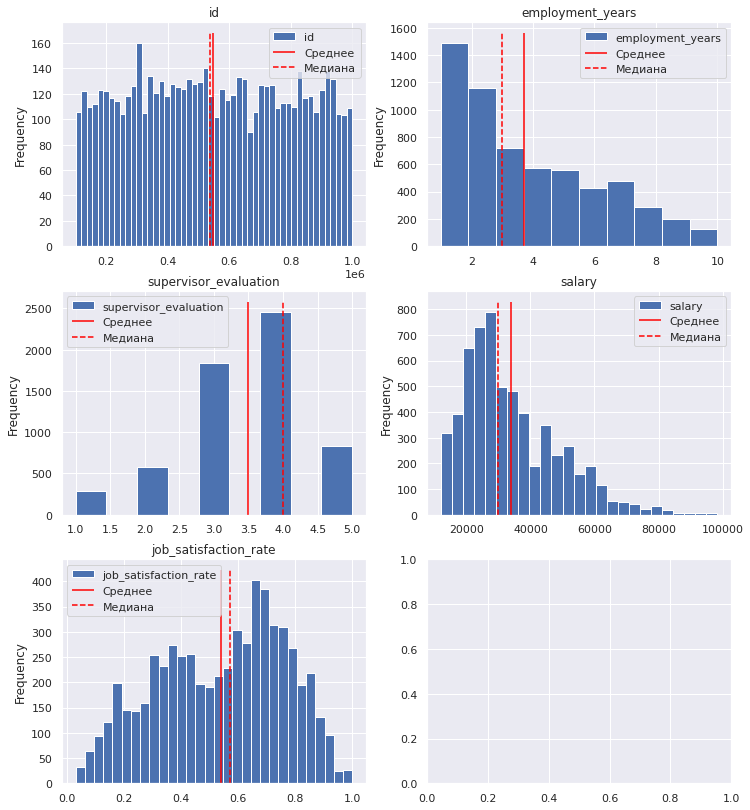

In [8]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 14))
bins=[50, 10, 9, 25, 30]

for j, i in enumerate(ds_main.select_dtypes(include='number').columns):
    ds_main[i].plot(kind='hist', title=i, ax=axes[j//2, j%2], bins=bins[j])
    ymin, ymax = axes[j//2, j%2].get_ylim()
    axes[j//2, j%2].vlines(x=ds_main[i].mean(), colors='red', ymin=ymin, ymax=ymax, label='Среднее')
    axes[j//2, j%2].vlines(x=ds_main[i].median(), colors='red', ymin=ymin, ymax=ymax, linestyles='--', label='Медиана')
    axes[j//2, j%2].legend()

Айди распределены сравнительно равномерно. Значения от 100.000, вплоть почти до миллиона, при том, что записей всего 6.000. Судя по всему, мы имеем дело со случайно отобранной выборкой.

Больше всего в компании сотрудников, устроившихся недавно, звучит логично. Вместе с увеличением длительности работы падает кол-во сотрудников.

Оценка качества работы представляет из себя только целые числа от 1 до 5, и больше смахивает на категориальный признак.

Зарплата, ожидаемо, концентрируется ближе к минимальным значениям, в компании больше людей с низкой зарплатой.

Уровень удовлетворенности имеет 2 пика. Удовлетворённость сотрудника чаще либо немного выше средней, либо немного ниже, реже - колеблется около 0.5, или сильно склоняется в одну из двух сторон.

В данных отсутствуют аномалии, отлично. Переходим дальше - к категориальным признакам.

Так как признак `supervisor_evaluation` показал сходство с категориальным типом данных - построим столбчатую диаграмму и для него. Заодно проверим наличие незначительно выбивающихся значений, которые не показала-бы гистограмма.

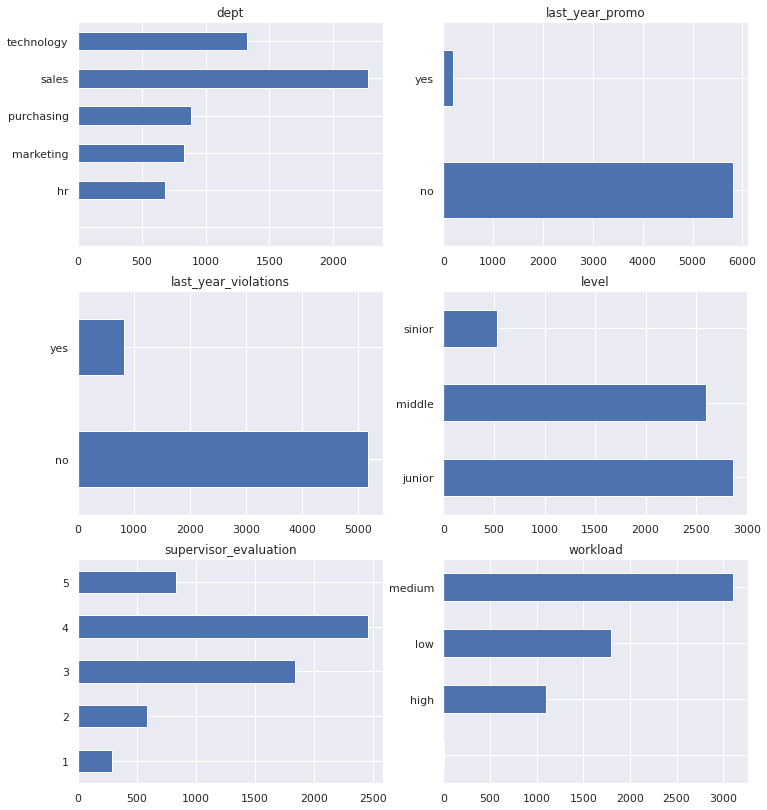

In [9]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 14))

for j, i in enumerate(ds_main.select_dtypes(exclude='number').columns.union(['supervisor_evaluation'])):
    ds_main[i].value_counts().sort_index().plot(kind='barh', title=i, ax=axes[j//2, j%2])

Самый крупный отдел в компании - отдел продаж.

Повышения выдаются неохотно. 

Также неохотно происходят нарушения трудового договора. 

Распределение уровня должностей похоже на правдивое. 

Барплот оценки качества работы показал ту-же картину, что и гистограмма. Значения в действительности распределены между пятью категориями. 

Уровень загруженности тоже не даёт повода заподозрить здесь ошибку.

Подозрительный отступ в загруженности и списке отделов. Попросим вывести уникальные значения этих признаков в каждом датасете.

In [10]:
for i in ds_train_sat, X_test:
    print(i['workload'].unique())
    print(i['dept'].unique())

['medium' 'high' 'low']
['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
['medium' 'low' 'high' ' ']
['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']


В тестовых данных виднеется пара увлекательных записей

In [11]:
X_test[(X_test['workload'] == ' ')|(X_test['dept'] == ' ')]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
15,590867,marketing,junior,,4,no,no,4,28800
1699,822186,,middle,medium,3,no,no,4,38400


А вот и наши ошибки. Изменим пропуски на NaN

In [12]:
X_test.loc[X_test['id'] == 822186, 'dept'] = np.nan
X_test.loc[X_test['id'] == 590867, 'workload'] = np.nan
for i in ['dept', 'workload']:
    print(X_test[i].unique())

['marketing' 'hr' 'sales' 'purchasing' 'technology' nan]
['medium' 'low' 'high' nan]


## Исследовательский анализ

На распределения данных мы уже посмотрели на этапе предобработки. Вернёмся к количественным признакам и взглянем на выбросы, построив ящиковые диаграммы. 

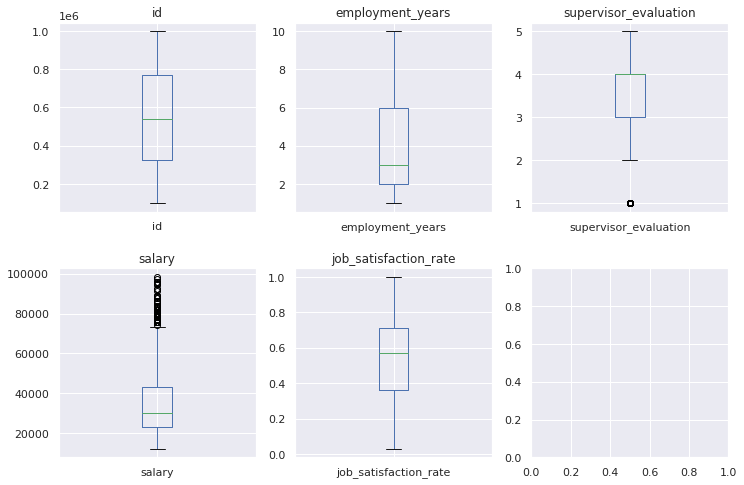

In [13]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

for j, i in enumerate(ds_main.select_dtypes(include='number').columns):
    ds_main[i].plot(kind='box', title=i, ax=axes[j//3, j%3])
plt.subplots_adjust(hspace=0.3)

В значениях зарплаты много выбросов - сотрудники, чья зарплата выше 70.000 выбиваются из общей картины, но нам нельзя пренебречь этими значениями, иначе модель будет плохо предсказывать уход сотрудников с высокой зарплатой. 

Также имеются выбросы в значениях оценки качества работы. Низкие значения ставятся достаточно редко, из-за чего единица находится за пределами нижнего уса, они нам также пригодятся.

Теперь займёмся корреляцией. Начнём с матрицы корреляции Спирмана.

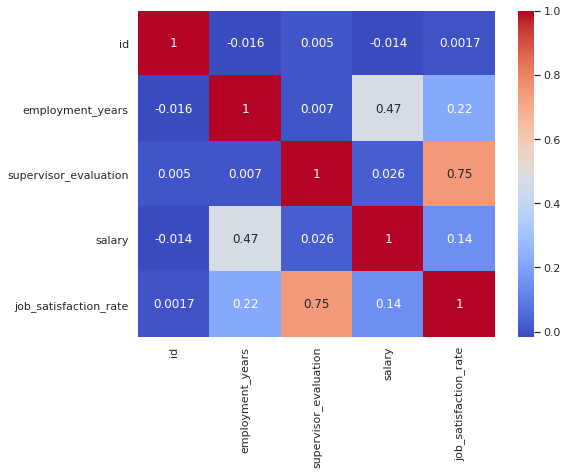

In [14]:
plt.figure(figsize=(8, 6))
sns.heatmap(ds_main.corr(method='spearman'), annot=True, cmap='coolwarm');

На уровень удовлетворённости прямо и достаточно сильно влияет оценка качества работы сотрудника. И имеется слабая корреляция с длительностью работы и зарплатой.

Также слабо коррелируют между собой зарплата и длительность работы, но до мультиколлинеарности им ещё далеко.

Теперь посмотрим на матрицу взаимосвязи библиотеки phik. Здесь мы сможем увидеть также и зависимости категориальных признаков

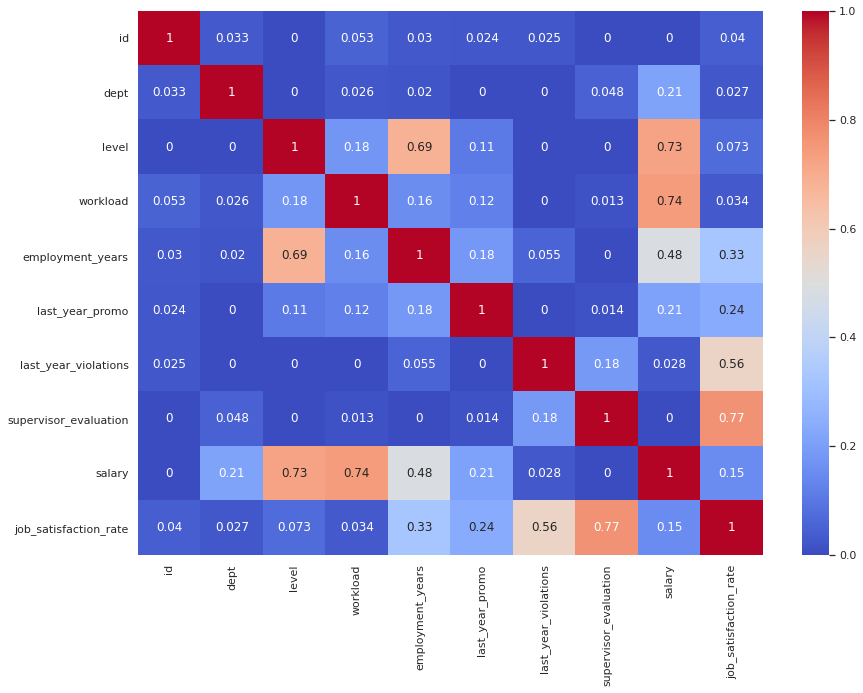

In [15]:
plt.figure(figsize=(14, 10))
sns.heatmap(ds_main.phik_matrix(interval_cols=ds_main.select_dtypes(include='number').columns), annot=True, cmap='coolwarm');

Похожая картина, что и в матрице корреляции Спирмена, также видна зависимость удовлетворенности от наличия нарушений.

## Подготовка данных

Для начала создадим пайплайны для кодирования данных. У нас много категориальных признаков, и у некоторых из них есть последовательные значения. Например, уровень должности. Для таких признаков используем `OrdinalEncoder`, он назначит каждому значению число согласно переданной последовательности.

In [16]:
ord_pipe = Pipeline([
    ('impute_before', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ord', OrdinalEncoder(categories=[
        ['junior', 'middle', 'sinior'],
        ['low', 'medium', 'high']
    ], handle_unknown='use_encoded_value', unknown_value=np.nan)),
    ('impute_after', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
])

Все остальные признаки закодируем при помощи `OneHotEncoder`.

In [17]:
ohe_pipe = Pipeline([
    ('impute_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ohe', OneHotEncoder(sparse=False, drop='first'))
])

Нам потребуется расфасовать названия столбцов, что и где мы будем кодировать/масштабировать. И сразу-же объединим все пайплайны при помощи `ColumnTransformer`

In [18]:
ohe_columns = ['last_year_promo', 'last_year_violations', 'dept']
ord_columns = ['level', 'workload']
num_columns = ['employment_years', 'supervisor_evaluation', 'salary']

data_preprocessor = ColumnTransformer([
    ('ohe_encode', ohe_pipe, ohe_columns),
    ('ord_encode', ord_pipe, ord_columns),
    ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

На этом подготовка данных завершена, у нас есть пайплайны для препроцессинга, и на следующем шаге мы объединим его с самой моделью.

## Обучение моделей

In [19]:
X_train = ds_train_sat.drop('job_satisfaction_rate', axis=1).set_index('id')
y_train = ds_train_sat['job_satisfaction_rate']

Теперь создадим финальные пайплайны. Мы проверим 2 модели - линейную регрессию и регрессор дерева решений. Для каждого создадим свой итоговый пайплайн, и позже сравним значения метрик.

In [20]:
pipe_linear = Pipeline([
    ('preprocessor', data_preprocessor),
    ('model', LinearRegression())
])
pipe_tree = Pipeline([
    ('preprocessor', data_preprocessor),
    ('model', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

Кстати о метрике - мы будем использовать SMAPE. Это симметричная средняя абсолютная процентная ошибка, её нет в библиотеке sklearn, поэтому создадим её сами. Для этого инициализируем функцию с расчётами.

In [21]:
def smape(true, pred):
    error = np.abs(true - pred)
    scale = (np.abs(true) + np.abs(pred)) / 2
    return np.mean(error / scale) * 100

И используем `make_scorer`, передав ему нашу функцию, и параметр `greater_is_better` равный False. SMAPE показывает процент содержания ошибок в ответах модели. Соответственно, высокое значение SMAPE - это значит, что модель работает плохо.

In [22]:
smape_score = make_scorer(smape, greater_is_better=False)

Создаём объект OptunaSearchCV, он будет заниматься для нас поиском лучших параметров. Для этого ему понадобится сетка параметров param_grid. Начнём с линейной модели, у неё не так много параметров, и хватит всего 2 итераций.

In [23]:
param_grid_linear={
    'model__fit_intercept':distributions.CategoricalDistribution([True, False])
}

cval_linear = OptunaSearchCV(
    pipe_linear,
    param_distributions=param_grid_linear,
    scoring=smape_score,
    n_jobs=-1,
    cv=8,
    n_trials=2,
    random_state=RANDOM_STATE
) 

/tmp/ipykernel_504/2617086103.py:5: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  cval_linear = OptunaSearchCV(


А у дерева решений параметров значительно больше. Переберём 10 комбинаций.

In [24]:
param_grid_tree={
    'model__max_depth':distributions.IntDistribution(3, 10),
    'model__min_samples_split':distributions.IntDistribution(2, 8),
    'model__min_samples_leaf':distributions.IntDistribution(2, 8)
}

cval_tree = OptunaSearchCV(
    pipe_tree,
    param_distributions=param_grid_tree,
    scoring=smape_score,
    n_jobs=-1,
    cv=8,
    n_trials=10,
    random_state=RANDOM_STATE
) 

/tmp/ipykernel_504/1607381658.py:7: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  cval_tree = OptunaSearchCV(


In [25]:
%time cval_linear.fit(X_train, y_train)
print('Лучшая оценка:', cval_linear.best_score_, 'с параметрами - ')
cval_linear.best_params_

[I 2024-05-14 10:12:44,823] A new study created in memory with name: no-name-18bf1556-3716-4e6a-ae6b-bfe869c747d7
[I 2024-05-14 10:12:46,302] Trial 1 finished with value: -25.032744771783463 and parameters: {'model__fit_intercept': True}. Best is trial 1 with value: -25.032744771783463.
[I 2024-05-14 10:12:46,366] Trial 0 finished with value: -25.032744771783463 and parameters: {'model__fit_intercept': True}. Best is trial 1 with value: -25.032744771783463.


CPU times: user 1.15 s, sys: 502 ms, total: 1.65 s
Wall time: 1.64 s
Лучшая оценка: -25.032744771783463 с параметрами - 


{'model__fit_intercept': True}

Значение метрики -25. Всё сломалось? Нет, мы с вами наблюдаем костыль планетарного масштаба - последствия применения параметра "greater_is_better=False". Дело в том, что наш кросс-валидатор не умеет работать с метриками, высокое значение которых означает плохое качество модели. Поэтому значения этих метрик отражаются зеркально, из-за чего сейчас мы видим самое высокое значение метрики, но при этом самое низкое по модулю - 25%

In [26]:
%time cval_tree.fit(X_train, y_train)
print('Лучшая оценка:', cval_tree.best_score_, 'с параметрами - ')
cval_tree.best_params_

[I 2024-05-14 10:12:46,476] A new study created in memory with name: no-name-6b06225a-7153-47c0-a693-ae5435ed66d7
[I 2024-05-14 10:12:50,126] Trial 0 finished with value: -16.68516449422655 and parameters: {'model__max_depth': 8, 'model__min_samples_split': 8, 'model__min_samples_leaf': 6}. Best is trial 0 with value: -16.68516449422655.
[I 2024-05-14 10:12:50,181] Trial 4 finished with value: -18.77452296594591 and parameters: {'model__max_depth': 6, 'model__min_samples_split': 3, 'model__min_samples_leaf': 7}. Best is trial 0 with value: -16.68516449422655.
[I 2024-05-14 10:12:50,361] Trial 5 finished with value: -17.835427770459194 and parameters: {'model__max_depth': 7, 'model__min_samples_split': 7, 'model__min_samples_leaf': 3}. Best is trial 0 with value: -16.68516449422655.
[I 2024-05-14 10:12:50,386] Trial 1 finished with value: -16.058813534651684 and parameters: {'model__max_depth': 9, 'model__min_samples_split': 3, 'model__min_samples_leaf': 8}. Best is trial 1 with value: 

CPU times: user 4.12 s, sys: 537 ms, total: 4.65 s
Wall time: 4.7 s
Лучшая оценка: -15.57475787829761 с параметрами - 


{'model__max_depth': 10,
 'model__min_samples_split': 3,
 'model__min_samples_leaf': 5}

In [28]:
smape(y_test_sat['job_satisfaction_rate'], cval_tree.predict(X_test.drop('id', axis=1)))

48.87035882287103